<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/Spacing%2BLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Load data
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Upload the file (you already did this once, but keep for completeness)
uploaded = files.upload()

Saving cf_pair25_v1.csv to cf_pair25_v1.csv


Training pairs: 20 | Testing pairs: 5
Calibrated (MLE on spacing) params [a, b]: [0.37042562 0.36788195]

Validation (spacing log-likelihood) summary:
       Vehicle_ID_f  LogLik_spacing
count      5.000000        5.000000
mean    4445.200000    -3202.236881
std     2617.051719     4119.225959
min     1939.000000   -10542.644503
25%     3054.000000    -1650.282227
50%     4094.000000    -1555.878899
75%     4330.000000    -1513.924716
max     8809.000000     -748.454063


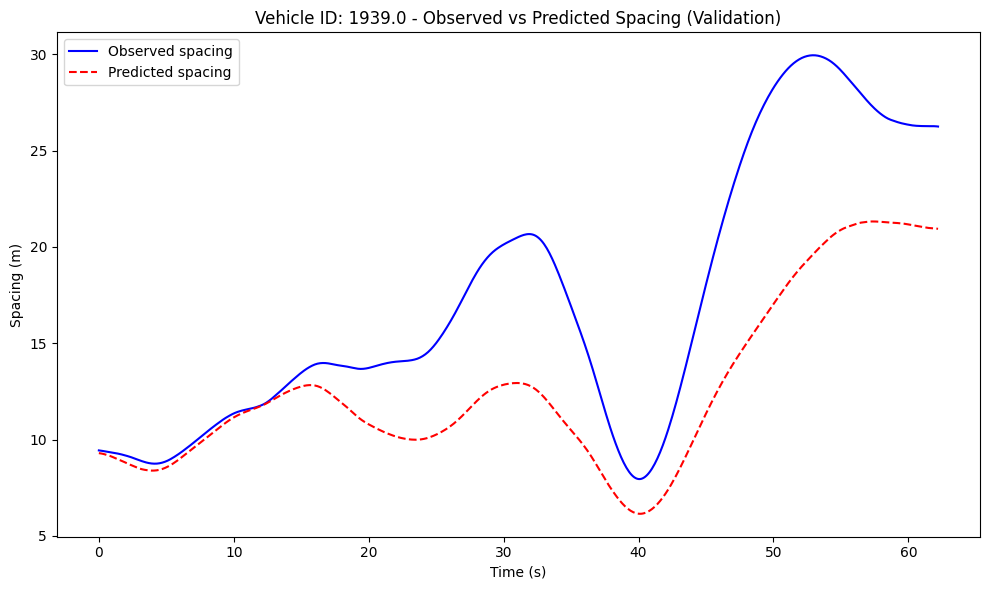

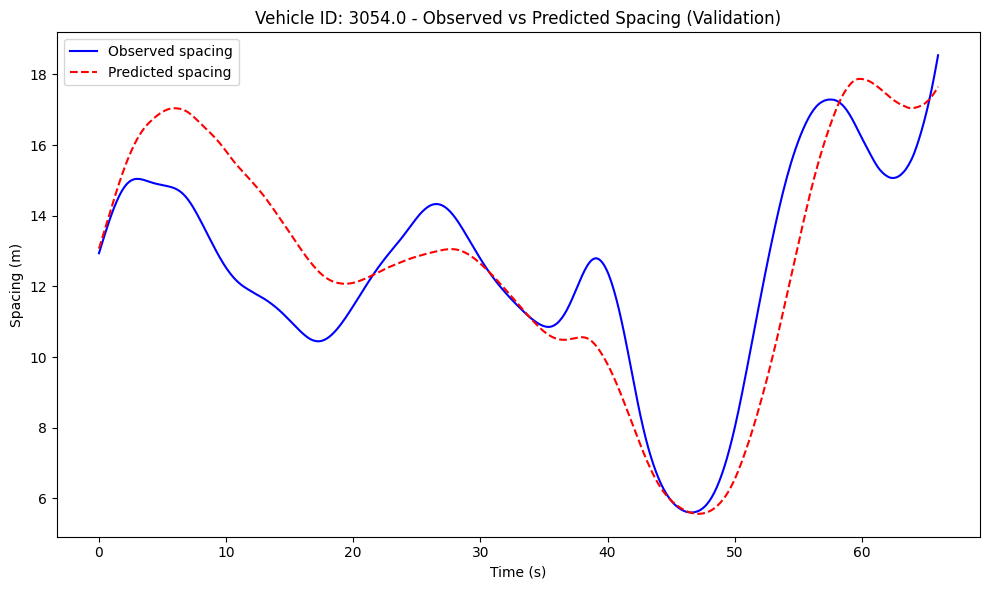

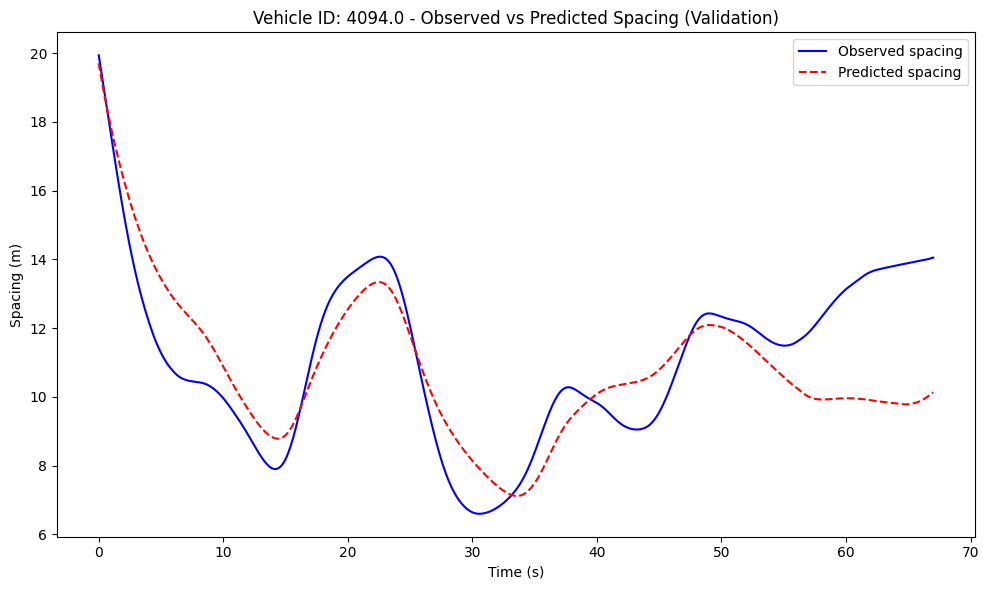

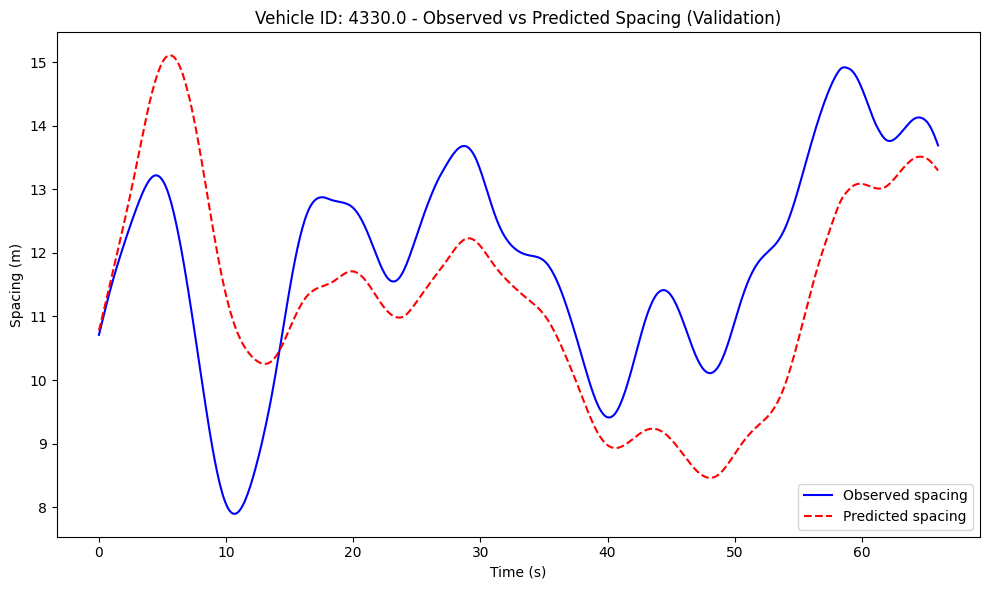

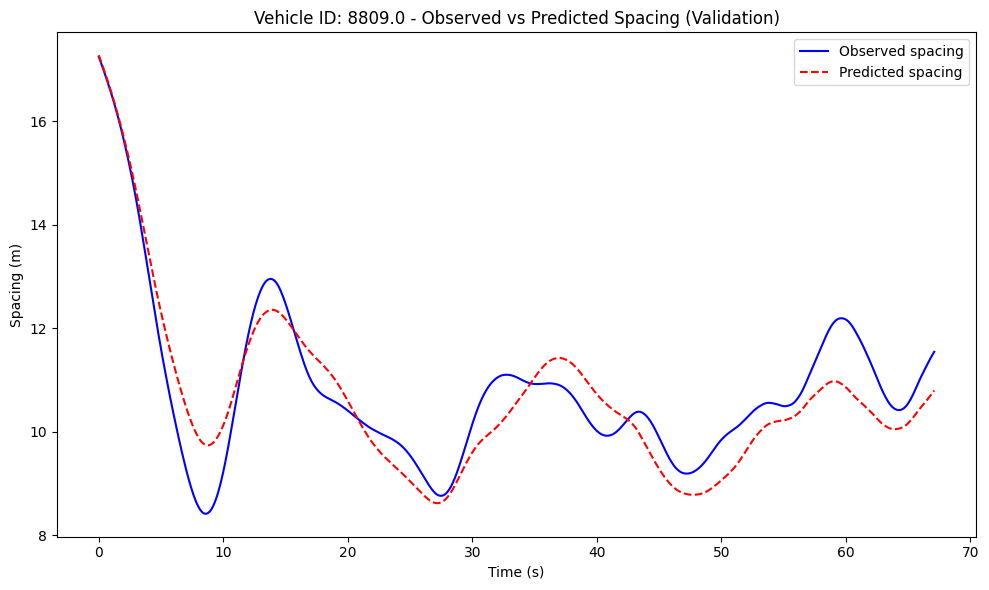

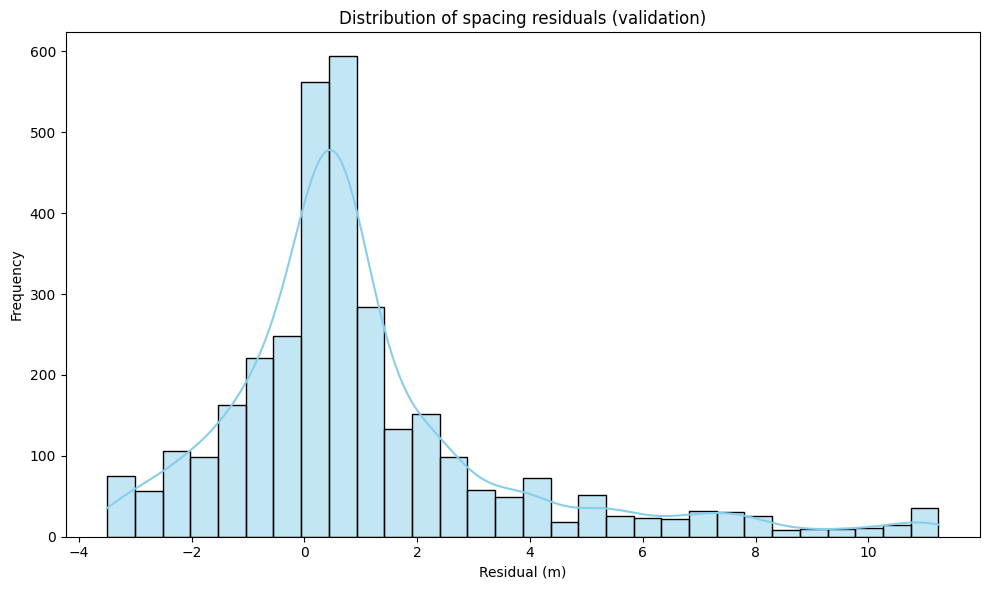

Shapiro–Wilk on spacing residuals: stat=0.860, p=0.000
Interpretation: Reject normality (p<=0.05)


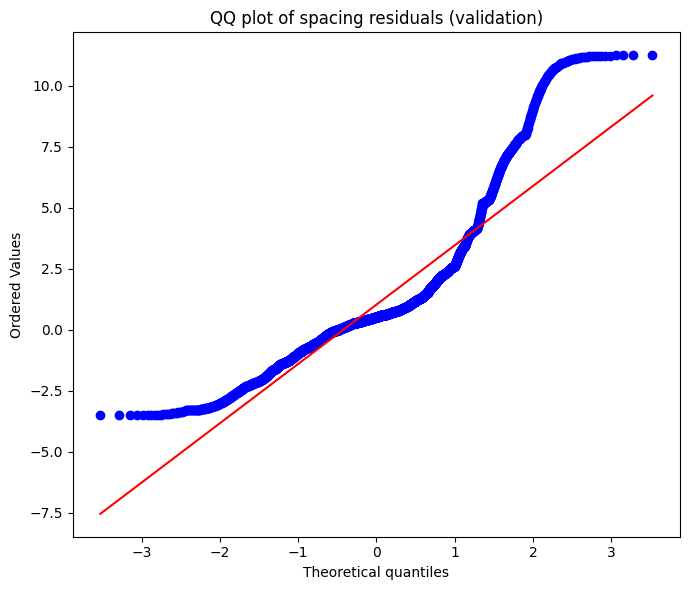


Validation (spacing RMSE) summary:
       Vehicle_ID_f  RMSE_spacing
count      5.000000      5.000000
mean    4445.200000      2.277480
std     2617.051719      1.946783
min     1939.000000      0.624231
25%     3054.000000      1.656150
50%     4094.000000      1.673205
75%     4330.000000      1.776348
max     8809.000000      5.657463


In [2]:
# Maximum Likelihood calibration of IDM on spacing (train/test split, validation, residual diagnostics)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import scipy.stats as stats

# ------------------------------------------------------------
# 0) Load data
# ------------------------------------------------------------
df = pd.read_csv('cf_pair25_v1.csv')

# If no spacing column, compute it: s = x_l - x_f - length_l
if 'spacing' not in df.columns:
    if not {'x_l', 'x_f', 'length_l'}.issubset(df.columns):
        raise ValueError("Need columns x_l, x_f, length_l to compute spacing.")
    df['spacing'] = df['x_l'] - df['x_f'] - df['length_l']

# ------------------------------------------------------------
# 1) Train/test split by follower vehicle (8:2)
# ------------------------------------------------------------
unique_pairs = df['Vehicle_ID_f'].unique()
train_ids, test_ids = train_test_split(unique_pairs, test_size=0.2, random_state=42)

train_data = df[df['Vehicle_ID_f'].isin(train_ids)].copy()
test_data  = df[df['Vehicle_ID_f'].isin(test_ids)].copy()

print(f"Training pairs: {len(train_ids)} | Testing pairs: {len(test_ids)}")

# ------------------------------------------------------------
# 2) IDM model + simulation
# ------------------------------------------------------------
def idm_model(s, v, delta_v, params, T=1.5, v0=30.0, s0=1.0, delta=4):
    """IDM acceleration given spacing s, follower speed v, relative speed delta_v."""
    a, b = params
    # Numerical guards
    a = max(a, 1e-6)
    b = max(b, 1e-6)
    s = max(s, 1e-3)
    s_star = s0 + v * T + (v * delta_v) / (2.0 * np.sqrt(a * b))
    return a * (1.0 - (v / v0) ** delta - (s_star / s) ** 2)

def simulate_vehicle(group, params, dt=0.1):
    """Simulate follower trajectory for one car-following pair."""
    v_f0 = group['v_f'].iloc[0]
    x_f0 = group['x_f'].iloc[0]
    v_l = group['v_l'].values
    x_l = group['x_l'].values
    length_l = group['length_l'].values

    v_sim = [v_f0]
    x_sim = [x_f0]
    s_sim = [x_l[0] - x_f0 - length_l[0]]

    for i in range(1, len(group)):
        s = x_l[i] - x_sim[-1] - length_l[i]
        delta_v = v_sim[-1] - v_l[i]
        acc = idm_model(s, v_sim[-1], delta_v, params)
        new_v = max(0.0, v_sim[-1] + acc * dt)  # avoid negative speeds
        new_x = x_sim[-1] + new_v * dt
        v_sim.append(new_v)
        x_sim.append(new_x)
        s_sim.append(x_l[i] - new_x - length_l[i])

    return np.array(v_sim), np.array(x_sim), np.array(s_sim)

# ------------------------------------------------------------
# 3) Maximum Likelihood objective on spacing residuals
# ------------------------------------------------------------
def neg_log_likelihood_spacing(params, df, dt=0.1, sigma=1.0):
    """Negative log-likelihood assuming Gaussian errors on spacing."""
    total_ll = 0.0
    const = np.log(2.0 * np.pi * sigma**2)
    for _, grp in df.groupby('Vehicle_ID_f'):
        s_obs = grp['spacing'].values
        _, _, s_sim = simulate_vehicle(grp, params, dt=dt)
        # Align lengths if any mismatch occurs
        n = min(len(s_obs), len(s_sim))
        resid = s_obs[:n] - s_sim[:n]
        total_ll += -0.5 * np.sum((resid / sigma)**2 + const)
    return -total_ll  # minimize negative log-likelihood

# ------------------------------------------------------------
# 4) Calibrate on training data (MLE on spacing)
# ------------------------------------------------------------
initial_guess = [1.0, 2.0]          # a, b
bounds = [(0.1, 5.0), (0.1, 5.0)]   # reasonable ranges

res = minimize(neg_log_likelihood_spacing, initial_guess,
               args=(train_data,), bounds=bounds, method='L-BFGS-B')
params_mle = res.x
print("Calibrated (MLE on spacing) params [a, b]:", params_mle)

# ------------------------------------------------------------
# 5) Validate on test data: log-likelihood + plots
# ------------------------------------------------------------
def evaluate_spacing_ll(df, params, dt=0.1, sigma=1.0):
    ll_values = []
    for vid, grp in df.groupby('Vehicle_ID_f'):
        s_obs = grp['spacing'].values
        _, _, s_sim = simulate_vehicle(grp, params, dt=dt)
        n = min(len(s_obs), len(s_sim))
        resid = s_obs[:n] - s_sim[:n]
        ll = -0.5 * np.sum((resid / sigma) ** 2 + np.log(2 * np.pi * sigma**2))
        ll_values.append({'Vehicle_ID_f': vid, 'LogLik_spacing': ll})
    return pd.DataFrame(ll_values)

eval_df = evaluate_spacing_ll(test_data, params_mle)
print("\nValidation (spacing log-likelihood) summary:")
print(eval_df.describe())

# Plot observed vs predicted spacing for each test vehicle
dt = 0.1
for vehicle_id, grp in test_data.groupby('Vehicle_ID_f'):
    s_obs = grp['spacing'].values
    _, _, s_sim = simulate_vehicle(grp, params_mle, dt=dt)
    n = min(len(s_obs), len(s_sim))
    t = np.arange(n) * dt

    plt.figure(figsize=(10, 6))
    plt.plot(t, s_obs[:n], label="Observed spacing", color="blue")
    plt.plot(t, s_sim[:n], label="Predicted spacing", color="red", linestyle='--')
    plt.title(f"Vehicle ID: {vehicle_id} - Observed vs Predicted Spacing (Validation)")
    plt.xlabel("Time (s)")
    plt.ylabel("Spacing (m)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 6) Residual diagnostics on test set (spacing residuals)
# ------------------------------------------------------------
def collect_spacing_residuals(df, params, dt=0.1):
    resid_all = []
    for _, grp in df.groupby('Vehicle_ID_f'):
        s_obs = grp['spacing'].values
        _, _, s_sim = simulate_vehicle(grp, params, dt=dt)
        n = min(len(s_obs), len(s_sim))
        resid_all.append(s_obs[:n] - s_sim[:n])
    return np.concatenate(resid_all)

spacing_resid = collect_spacing_residuals(test_data, params_mle, dt=dt)

# Histogram + KDE
plt.figure(figsize=(10,6))
sns.histplot(spacing_resid, bins=30, kde=True, color="skyblue")
plt.title("Distribution of spacing residuals (validation)")
plt.xlabel("Residual (m)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Shapiro–Wilk normality test (subset if very large)
subset = spacing_resid[:min(len(spacing_resid), 5000)]
stat, p_value = stats.shapiro(subset)
print(f"Shapiro–Wilk on spacing residuals: stat={stat:.3f}, p={p_value:.3f}")
print("Interpretation:",
      "Fail to reject normality (p>0.05)" if p_value > 0.05 else "Reject normality (p<=0.05)")

# QQ plot
plt.figure(figsize=(7,6))
stats.probplot(spacing_resid, dist="norm", plot=plt)
plt.title("QQ plot of spacing residuals (validation)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7) Optional: report RMSE of spacing for context
# ------------------------------------------------------------
def evaluate_spacing_rmse(df, params, dt=0.1):
    rows = []
    for vid, grp in df.groupby('Vehicle_ID_f'):
        s_obs = grp['spacing'].values
        _, _, s_sim = simulate_vehicle(grp, params, dt=dt)
        n = min(len(s_obs), len(s_sim))
        resid = s_obs[:n] - s_sim[:n]
        rmse = np.sqrt(np.mean(resid**2))
        rows.append({'Vehicle_ID_f': vid, 'RMSE_spacing': rmse})
    return pd.DataFrame(rows)

rmse_df = evaluate_spacing_rmse(test_data, params_mle, dt=dt)
print("\nValidation (spacing RMSE) summary:")
print(rmse_df.describe())
